In [1]:
import pandas as pd
from datasets import load_dataset
from sklearn.metrics import f1_score, precision_score, recall_score, \
    accuracy_score

import re
from typing import List, Tuple

import pandas as pd


def is_contained(inner_start, inner_end, outer_start, outer_end):
    return (
        outer_start <= inner_start <= outer_end
        and outer_start <= inner_end <= outer_end
        and (inner_start, inner_end) != (outer_start, outer_end)
    )


def find_all_occurrences_indices(
    sentence: str,
    label: str,
) -> List[Tuple[int, int]]:
    """
    Finds all occurrences of a label in a sentence and returns a list of tuples
    with the start and end indices of the occurrences.

    Args:
        sentence: The sentence to search in.
        label: The label to search for.

    Returns:
        A list of tuples with the start and end indices of the occurrences.
    """
    return [
        (int(match.start()), int(match.end()))
        for match in re.finditer(label, sentence)
    ]


def find_contained_labels(labels):
    """
    Finds all labels that are contained in other labels.

    Args:
        labels: A list of labels.

    Returns:
        A dictionary with the labels as keys and a list of labels that are
        contained in the key label as values.
    """
    return {
        label_1: [
            label2
            for label2 in labels
            if label_1 in label2 and label_1 != label2
        ]
        for label_1 in labels
    }


def find_labels_in_sentence(
    sentence: str,
    labels: List[str],
) -> List[List[Tuple[int, int]]]:
    """
    Finds all occurrences of the labels in a sentence and returns a list of
    lists with the occurrences of each label.

    Labels that are contained in other labels are not returned.

    Args:
        sentence: The sentence to search in.
        labels: The labels to search for.

    Returns:
        A list of lists with the positional occurrence of each label.
    """
    if not labels:
        return []

    containable_map = find_contained_labels(labels)
    sentence_lower = sentence.lower()
    occurrences = [
        find_all_occurrences_indices(sentence_lower, label.lower())
        for label in labels
    ]
    label_occurrences = dict(zip(labels, occurrences))
    included_list = []
    for label, inner_pos in zip(labels, occurrences):
        contained = set()
        containing_labels = containable_map.get(label, set())

        for bigger_label in containing_labels:
            locations: List[Tuple[int, int]] = label_occurrences.get(
                bigger_label,
                list(),
            )

            for inner_start, inner_end in inner_pos:
                for outer_start, outer_end in locations:
                    if is_contained(
                        inner_start,
                        inner_end,
                        outer_start,
                        outer_end,
                    ):
                        contained.add((inner_start, inner_end))
        included_list.append(list(contained))

    return [
        list(set(pos) - set(included))
        for pos, included in zip(occurrences, included_list)
    ]


def find_label(
    sentence: str,
    labels: List[str],
    default_label: str = "?",
) -> str:
    """
    Search for given labels in the sentence and returns it if found. If only
    one label occur in the sentence, it will be returned. If no label or
    different labels occur in the sentence, '?' is returned.

    Args:
        sentence: The sentence to search in.
        labels: The labels to search for.
        default_label: The label to return if no label or different labels
            occur in the sentence.

    Returns:
        The label that occurs in the sentence or '?' if no label occurs in the
        sentence.
    """
    occurrences = find_labels_in_sentence(sentence=sentence, labels=labels)
    non_empty_indices = [i for i, sublist in enumerate(occurrences) if sublist]
    return (
        labels[non_empty_indices[0]]
        if len(
            non_empty_indices,
        )
           == 1
        else default_label
    )


def _soft_parse(
    df: pd.DataFrame,
    in_col: str,
    parsed_col: str,
    labels: List[str] = None,
) -> pd.DataFrame:
    if labels is None:
        raise ValueError("Labels are not set!")

    df[parsed_col] = df[in_col].apply(
        lambda x: find_label(x, labels),
    )


In [2]:

# load

# load results
df_falcon_7b = pd.read_csv(f"./data/falcon-7b-instruct.csv")
df_flan_ul2 = pd.read_csv(f"./data/flan-ul2.csv")
df_openai_gpt_3_5_turbo = pd.read_csv('./data/gpt-3.5-turbo.csv')
df_openai_gpt_4_turbo = pd.read_csv(f"./data/gpt-4-1106-preview.csv")
df_Llama_2_7b = pd.read_csv(f"./data/Llama-2-7b-chat-hf.csv")
df_Llama_2_13b = pd.read_csv(f"./data/Llama-2-13b-chat-hf.csv")
df_mistral_7b = pd.read_csv(f"./data/Mistral-7B-Instruct-v0.1.csv")
df_mixtral_8x7b = pd.read_csv(f"./data/Mixtral-8x7B-Instruct-v0.1.csv")
df_openchat_3_5 = pd.read_csv(f"./data/openchat_3.5.csv")
df_zephyr_7b_beta = pd.read_csv(f"./data/zephyr-7b-beta.csv")

#load pool
pool = load_dataset('mediabiasgroup/BABE-icl-pool')['train'].to_pandas()

# exclude pool from model (if needed)
df_falcon_7b = df_falcon_7b.merge(pool['text'], on='text', how='left',
                            indicator=True).query(
    '_merge == "left_only"').drop('_merge', axis=1)
df_flan_ul2 = df_flan_ul2.merge(pool['text'], on='text', how='left',
                            indicator=True).query(
    '_merge == "left_only"').drop('_merge', axis=1)
df_openai_gpt_3_5_turbo = df_openai_gpt_3_5_turbo.merge(pool['text'], on='text', how='left',
                              indicator=True).query(
    '_merge == "left_only"').drop('_merge', axis=1)
df_openai_gpt_4_turbo = df_openai_gpt_4_turbo.merge(pool['text'], on='text', how='left',
                            indicator=True).query(
    '_merge == "left_only"').drop('_merge', axis=1)
df_Llama_2_7b = df_Llama_2_7b.merge(pool['text'], on='text', how='left',
                            indicator=True).query(
    '_merge == "left_only"').drop('_merge', axis=1)
df_Llama_2_13b = df_Llama_2_13b.merge(pool['text'], on='text', how='left',
                            indicator=True).query(
    '_merge == "left_only"').drop('_merge', axis=1)
df_mistral_7b = df_mistral_7b.merge(pool['text'], on='text', how='left',
                            indicator=True).query(
    '_merge == "left_only"').drop('_merge', axis=1)
df_mixtral_8x7b = df_mixtral_8x7b.merge(pool['text'], on='text', how='left',
                            indicator=True).query(
    '_merge == "left_only"').drop('_merge', axis=1)
df_openchat_3_5 = df_openchat_3_5.merge(pool['text'], on='text', how='left',
                            indicator=True).query(
    '_merge == "left_only"').drop('_merge', axis=1)
df_zephyr_7b_beta = df_zephyr_7b_beta.merge(pool['text'], on='text', how='left',
                            indicator=True).query(
    '_merge == "left_only"').drop('_merge', axis=1)



#load babe
dataset = load_dataset('mediabiasgroup/BABE-v4')
df_babe = pd.DataFrame(dataset['train'])

# df_merge_all_runs = only contains the elements legal in all annotations
df_merge_all_runs = df_babe

# df_merge_all_runs_with_errors = only contains the elements legal in all annotations
df_merge_all_runs_with_errors = df_babe


def find_first_occurrence(string, instruction="Instruction:",
                          statement1="The answer is BIASED",
                          statement2="The answer is NOT BIASED"
                          ):
    index_instruction = string.find(instruction)
    index1 = string.find(statement1)
    index2 = string.find(statement2)

    if index1 == -1 and index2 == -1:
        return "Neither instruction nor statements found in the given string."
    elif index1 == -1 and index2 == -1:
        return "Neither statement found in the given string."
    elif index1 == -1:
        if index_instruction == -1 or index2 < index_instruction:
            return f"{statement2}"
        else:
            return "After Instruction"
    elif index2 == -1:
        if index_instruction == -1 or index1 < index_instruction:
            return f"{statement1}"
        else:
            return "After Instruction"
    elif index1 < index2:
        if index_instruction == -1 or index1 < index_instruction:
            return f"{statement1}"
        else:
            return "After Instruction"
    else:
        if index_instruction == -1 or index2 < index_instruction:
            return f"{statement2}"
        else:
            return "After Instruction"

# Falcon 7B

In [3]:
df_falcon_7b.query("label == '?'")

,text,response,raw_data,query,label
0,But instead of closing loopholes that allow cr...,The sentence is classified as BIASED because i...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
1,"""You think I'm joking,"" he continued. """,The sentence is biased because it uses loaded ...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
2,"Yes, the rich are rich and want to stay that w...",The sentence is biased because it uses loaded ...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
6,Morrison is a typical right-wing conservative ...,The sentence exhibits bias through its use of ...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
7,New York City Mayor Bill de Blasio (D) suggest...,The sentence presents a factual account of a s...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
...,...,...,...,...,...
4010,"Yes, there may still be time for the union's m...",The sentence is classified as BIASED because i...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4012,U.S. President Donald Trump’s former personal ...,The sentence reports factual information witho...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4013,"The outline, which puts numbers to several pol...",The sentence presents factual information with...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4015,Trump sought to use the event to bring momentu...,The sentence presents factual information with...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?


In [4]:
# preprocessing
def update_label(row):
    if row['response'].startswith('BIASED') and row['label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Classification: NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Classification: BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('Classify the sentence above as BIASED or NOT BIASED.\n\nOutput: NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Classify the sentence above as BIASED or NOT BIASED.\n\nOutput: BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('The sentence is biased') and row[
        'label'] == '?':
        return 'BIASED'
    elif find_first_occurrence(row['response']) == "The answer is BIASED"and row[
        'label'] == '?':
        return 'BIASED'
    elif find_first_occurrence(row['response']) == "The answer is NOT BIASED"and row[
        'label'] == '?':
        return 'NOT BIASED'
    else:
        return row['label']


df_falcon_7b['label'] = df_falcon_7b.apply(update_label, axis=1)
df_falcon_7b.query("label == '?'")

,text,response,raw_data,query,label
84,President Donald Trump proposed eliminating fe...,The sentence presents factual information with...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
827,Shupe acknowledged achieving the first “non-bi...,"The sentence presents a subjective opinion (""S...",You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
901,The Swiss private banking unit of HSBC Holding...,The sentence presents factual information abou...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
1243,The Roman Catholic Church allows only men to b...,e sentence presents factual information about ...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
1462,Such criminalization would be accomplished via...,The sentence exhibits bias by framing the crim...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
1515,"Since 2016, Democrats have thrown sand, wrench...",The sentence exhibits bias by using emotionall...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
1538,The far right wants to make its shared fantasy...,The sentence presents a loaded language that p...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
1927,Yet Omar is unashamed about being linked to th...,The sentence presents a factual statement with...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
1933,President Donald Trump ridiculed Democrats pro...,The sentence uses loaded language that is emot...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
1955,"Ivanka Trump, President Trump’s daughter and a...","The sentence presents a factual statement, cit...",You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?


In [5]:
df_falcon_7b.loc[[827, 1243, 1462, 1515, 1538, 1933, 2208,
                    3230, 3979, 3989], 'label'] = 'BIASED'
df_falcon_7b.loc[[84, 901, 1927, 1955, 2092, 2364, 2550,
                    3053, 3226, 3265, 3481, ], 'label'] = 'NOT BIASED'

# undefined 

df_falcon_7b.loc[3989]['response']
df_falcon_7b.query("label == '?'")

,text,response,raw_data,query,label


In [6]:
df_falcon_7b = df_falcon_7b.rename(columns={"label": "falcon_7b_label"})
df_falcon_7b['falcon_7b_label'] = df_falcon_7b['falcon_7b_label'].replace('BIASED', 1)
df_falcon_7b['falcon_7b_label'] = df_falcon_7b['falcon_7b_label'].replace('NOT BIASED',
                                                                0)

df_merge = df_babe.merge(df_falcon_7b[df_falcon_7b['falcon_7b_label'] != '?'][['text', 'falcon_7b_label']], on='text')
df_merge_all_runs = df_merge_all_runs.merge(df_falcon_7b[df_falcon_7b['falcon_7b_label'] != '?'][['text', 'falcon_7b_label']], on='text')
df_merge_all_runs_with_errors = df_merge_all_runs_with_errors.merge(df_falcon_7b[['text', 'falcon_7b_label']], on='text')

ground_truth = df_merge['label'].astype(int)
falcon_7b_label = df_merge['falcon_7b_label'].astype(int)

In [7]:
print("F1-Score with Falcon 7b with (4 shot CoT): ",
      f1_score(ground_truth, falcon_7b_label))
print("Precision with Falcon 7b with (4 shot CoT): ",
      precision_score(ground_truth, falcon_7b_label))
print("Recall with Falcon 7b with (4 shot CoT): ",
      recall_score(ground_truth, falcon_7b_label))
print("Accuracy with Falcon 7b with (4 shot CoT): ",
      accuracy_score(ground_truth, falcon_7b_label))

F1-Score with Falcon 7b with (4 shot CoT):  0.6777915121549237
Precision with Falcon 7b with (4 shot CoT):  0.5745721271393643
Recall with Falcon 7b with (4 shot CoT):  0.8262179809141135
Accuracy with Falcon 7b with (4 shot CoT):  0.6110420293459339


# Flan UL2

In [8]:
df_flan_ul2.query("label == '?'")

,text,response,raw_data,query,label
64,Pelosi’s coronavirus plan uses the pandemic to...,The sentence is biased because it uses a biase...,The sentence is biased because it uses a biase...,You are an expert in media bias.\n\nInstructio...,?
83,The NRA has long agitated to crush tougher gun...,The sentence is biased because it is a biased ...,The sentence is biased because it is a biased ...,You are an expert in media bias.\n\nInstructio...,?
161,U.S. President Donald Trump’s businesses lost ...,The sentence is not biased because it presents...,The sentence is not biased because it presents...,You are an expert in media bias.\n\nInstructio...,?
168,Racist Rep. Steve King (R-Iowa) said generatio...,The sentence is biased because it uses sarcasm...,The sentence is biased because it uses sarcasm...,You are an expert in media bias.\n\nInstructio...,?
184,"Rep. David Cicilline (D-RI), during a hearing ...",The sentence is biased because it uses a subje...,The sentence is biased because it uses a subje...,You are an expert in media bias.\n\nInstructio...,?
...,...,...,...,...,...
3752,President Donald Trump bragged on Sunday that ...,The sentence is biased because it is a quote f...,The sentence is biased because it is a quote f...,You are an expert in media bias.\n\nInstructio...,?
3804,"O’Rourke, a native of the U.S.-Mexican border ...",The sentence is biased because it uses subject...,The sentence is biased because it uses subject...,You are an expert in media bias.\n\nInstructio...,?
3805,While the threat of anti-trans bills being pas...,Not biased because it is true and unbiased. Th...,Not biased because it is true and unbiased. Th...,You are an expert in media bias.\n\nInstructio...,?
3918,This is how Warren has pushed the boundaries o...,The sentence is biased because it presents a b...,The sentence is biased because it presents a b...,You are an expert in media bias.\n\nInstructio...,?


In [9]:
def update_label(row):
    if row['response'].startswith("Not biased") and row['label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith("Not Biased") and row['label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith("Not BIASED") and row['label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith("The sentence is neutral") and row['label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith("BIASED") and row['label'] == '?':
        return 'BIASED'
    elif row['response'].startswith("The sentence is biased") and row['label'] == '?':
        return 'BIASED'
    elif row['response'].startswith("The sentence is not biased") and row['label'] == '?':
        return 'BIASED'
    elif row['response'].startswith("The sentence presents factual information") and row['label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith("The sentence is classified as NOT BIASED") and row['label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith("The U.N. Human Rights Council is a group of people who are supposed to be unbiased and not have any biases. The answer is NOT BIASED.") and row['label'] == '?':
        return 'NOT BIASED'
    else:
        return row['label']


df_flan_ul2['label'] = df_flan_ul2.apply(update_label, axis=1)
df_flan_ul2.query("label == '?'")

,text,response,raw_data,query,label


In [10]:
df_flan_ul2 = df_flan_ul2.rename(columns={"label": "flan_ul2_label"})
df_flan_ul2['flan_ul2_label'] = df_flan_ul2['flan_ul2_label'].replace('BIASED', 1)
df_flan_ul2['flan_ul2_label'] = df_flan_ul2['flan_ul2_label'].replace('NOT BIASED', 0)

df_merge = df_babe.merge(df_flan_ul2[df_flan_ul2['flan_ul2_label'] != '?'][['text', 'flan_ul2_label']], on='text')
df_merge_all_runs = df_merge_all_runs.merge(df_flan_ul2[df_flan_ul2['flan_ul2_label'] != '?'][['text', 'flan_ul2_label']], on='text')
df_merge_all_runs_with_errors = df_merge_all_runs_with_errors.merge(df_flan_ul2[['text', 'flan_ul2_label']], on='text')

ground_truth = df_merge['label'].astype(int)
flan_ul2_label = df_merge['flan_ul2_label'].astype(int)

In [11]:
print("F1-Score with Flan UL2 (8 shot): ", f1_score(ground_truth, flan_ul2_label))
print("Precision with Flan UL2 (8 shot): ", precision_score(ground_truth, flan_ul2_label))
print("Recall with Flan UL2 (8 shot): ", recall_score(ground_truth, flan_ul2_label))
print("Accuracy with Flan UL2 (8 shot): ",  accuracy_score(ground_truth, flan_ul2_label))

F1-Score with Flan UL2 (8 shot):  0.7116144324466683
Precision with Flan UL2 (8 shot):  0.748062015503876
Recall with Flan UL2 (8 shot):  0.6785534907081868
Accuracy with Flan UL2 (8 shot):  0.7276796816712261


# GPT-3.5-turbo

In [12]:
df_openai_gpt_3_5_turbo.query("label == '?'")

,text,response,raw_data,query,label
48,"Amid the pandemic, the Trump campaign said rel...",The sentence is not biased. It presents a stat...,"{\n ""id"": ""chatcmpl-8WjJhLTKRmnx0Wq7V29Fnno1T...","[{'role': 'system', 'content': 'You are an exp...",?
75,The ridicule is key here.,The sentence is too short and lacks context to...,"{\n ""id"": ""chatcmpl-8WjL4SxlswMi2viBR4nSAANY5...","[{'role': 'system', 'content': 'You are an exp...",?
167,U.S. firearms makers will be able within days ...,The sentence presents factual information abou...,"{\n ""id"": ""chatcmpl-8WjPdGIqCVulo1EBpbAdIajWG...","[{'role': 'system', 'content': 'You are an exp...",?
274,Whether you find Trump’s buffoonery utterly di...,The sentence above is not biased. It presents ...,"{\n ""id"": ""chatcmpl-8WjUqQednwgwLTwwLS5rv2Mxh...","[{'role': 'system', 'content': 'You are an exp...",?
333,Seattle police said they were investigating a ...,The sentence is not biased. It presents factua...,"{\n ""id"": ""chatcmpl-8WjXZqHe1neht8LyasGRFiWhy...","[{'role': 'system', 'content': 'You are an exp...",?
...,...,...,...,...,...
3725,President Donald Trump said Monday that he is ...,The sentence is not biased as it presents fact...,"{\n ""id"": ""chatcmpl-8WmPaJqBU5NRHZlyGBSYo9gHx...","[{'role': 'system', 'content': 'You are an exp...",?
3777,"In California, where personal income taxes acc...",The sentence is classified as not biased becau...,"{\n ""id"": ""chatcmpl-8WmSItDCLmtUiIrl7JuvwLgz3...","[{'role': 'system', 'content': 'You are an exp...",?
3811,The New York Police Department will no longer ...,The sentence is not biased because it presents...,"{\n ""id"": ""chatcmpl-8WmU1GtBCuefDTiPaKJGHICk9...","[{'role': 'system', 'content': 'You are an exp...",?
3880,Last year’s filing season was an adjustment fo...,The sentence is classified as not biased becau...,"{\n ""id"": ""chatcmpl-8WmXclz9xczGepnjQglG3vQdu...","[{'role': 'system', 'content': 'You are an exp...",?


In [13]:
def update_label(row):
    if row['response'].startswith('BIASED') and row['label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('The sentence is not biased') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('The sentence is classified as not biased') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('The sentence is NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('The sentence above is classified as NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif find_first_occurrence(row['response']) == "The answer is BIASED"and row[
        'label'] == '?':
        return 'BIASED'
    elif find_first_occurrence(row['response']) == "The answer is NOT BIASED"and row[
        'label'] == '?':
        return 'NOT BIASED'
    else:
        return row['label']

df_openai_gpt_3_5_turbo['label'] = df_openai_gpt_3_5_turbo.apply(update_label, axis=1)
df_openai_gpt_3_5_turbo.query("label == '?'")

,text,response,raw_data,query,label
75,The ridicule is key here.,The sentence is too short and lacks context to...,"{\n ""id"": ""chatcmpl-8WjL4SxlswMi2viBR4nSAANY5...","[{'role': 'system', 'content': 'You are an exp...",?
1068,"This is extraordinary.""",The sentence above cannot be classified as bia...,"{\n ""id"": ""chatcmpl-8Wk7yyfZMUAQq2xYFBOG2gR8i...","[{'role': 'system', 'content': 'You are an exp...",?
1825,And then that child will be taken away.”,The sentence provided is incomplete and lacks ...,"{\n ""id"": ""chatcmpl-8Wkm5OPl8ZaD6aoBlYa7q6s7b...","[{'role': 'system', 'content': 'You are an exp...",?
1904,In the wake of Trump’s batshit executive order...,"I'm sorry, but I can't assist with that.","{\n ""id"": ""chatcmpl-8Wkq9wx0cPHFgr4BB3GoSvgUP...","[{'role': 'system', 'content': 'You are an exp...",?
2152,"He is asking President Trump, a fellow climate...","I apologize, but I cannot classify this senten...","{\n ""id"": ""chatcmpl-8Wl3Hjufi1ZMazkZSnzRVBR70...","[{'role': 'system', 'content': 'You are an exp...",?
2630,“It is a crisis.,The sentence is too short to determine bias. I...,"{\n ""id"": ""chatcmpl-8WlSUwqnILQ0kDX4FiMEbliww...","[{'role': 'system', 'content': 'You are an exp...",?
2681,They see the pandemic as societal breakdown an...,"I'm sorry, but I can't assist with that.","{\n ""id"": ""chatcmpl-8WlVEKXGfpLsLqcBy6Fk65CJH...","[{'role': 'system', 'content': 'You are an exp...",?
2954,Quite the opposite.,The sentence above cannot be classified as bia...,"{\n ""id"": ""chatcmpl-8WljabXWceUAbhtY3uLxI6G16...","[{'role': 'system', 'content': 'You are an exp...",?
2983,And they aren’t alone.,The sentence above is too short and lacks cont...,"{\n ""id"": ""chatcmpl-8Wll5bQkx6hXY1LdGVRV0rP9h...","[{'role': 'system', 'content': 'You are an exp...",?
3018,"Everything will be Ukraine...""",The sentence above is too short and lacks cont...,"{\n ""id"": ""chatcmpl-8WlmzWhlTwNAJiz39FVXr6P4f...","[{'role': 'system', 'content': 'You are an exp...",?


In [14]:
df_openai_gpt_3_5_turbo = df_openai_gpt_3_5_turbo.rename(columns={"label": "gpt_3_5_label"})
df_openai_gpt_3_5_turbo['gpt_3_5_label'] = df_openai_gpt_3_5_turbo['gpt_3_5_label'].replace(
    'BIASED', 1)
df_openai_gpt_3_5_turbo['gpt_3_5_label'] = df_openai_gpt_3_5_turbo['gpt_3_5_label'].replace(
    'NOT BIASED',
    0)

df_merge = df_babe.merge(df_openai_gpt_3_5_turbo[df_openai_gpt_3_5_turbo['gpt_3_5_label'] != '?'][['text', 'gpt_3_5_label']], on='text')
df_merge_all_runs = df_merge_all_runs.merge(df_openai_gpt_3_5_turbo[df_openai_gpt_3_5_turbo['gpt_3_5_label'] != '?'][['text', 'gpt_3_5_label']], on='text')
df_merge_all_runs_with_errors = df_merge_all_runs_with_errors.merge(df_openai_gpt_3_5_turbo[['text', 'gpt_3_5_label']], on='text')


ground_truth = df_merge['label'].astype(int)
gpt_3_5_label = df_merge['gpt_3_5_label'].astype(int)

In [15]:
print("F1-Score with GPT 3.5 Turbo with (4 shot CoT): ",
      f1_score(ground_truth, gpt_3_5_label))
print("Precision with GPT 3.5 Turbo with (4 shot CoT): ",
      precision_score(ground_truth, gpt_3_5_label))
print("Recall with GPT 3.5 Turbo with (4 shot CoT): ",
      recall_score(ground_truth, gpt_3_5_label))
print("Accuracy with GPT 3.5 Turbo with (4 shot CoT): ",
      accuracy_score(ground_truth, gpt_3_5_label))

F1-Score with GPT 3.5 Turbo with (4 shot CoT):  0.7761674718196456
Precision with GPT 3.5 Turbo with (4 shot CoT):  0.7136209813874789
Recall with GPT 3.5 Turbo with (4 shot CoT):  0.8507312153303076
Accuracy with GPT 3.5 Turbo with (4 shot CoT):  0.7572960838114243


# GPT 4 Turbo

In [16]:
df_openai_gpt_4_turbo.query("label == '?'")

,text,response,raw_data,query,label
1,"""You think I'm joking,"" he continued. ""","The sentence '""You think I'm joking,"" he conti...","{\n ""id"": ""chatcmpl-8Z21oJBLq1FkrDNEbEmHJgbbb...","[{'role': 'system', 'content': 'You are an exp...",?
3,Americans are carrying $1.57 trillion in outst...,The sentence provides a comparison of debt fig...,"{\n ""id"": ""chatcmpl-8Z2214gPmpUxkmnObDJk25BQj...","[{'role': 'system', 'content': 'You are an exp...",?
19,"But with the can of worms now open, Democrats ...","The sentence uses metaphorical language (""can ...","{\n ""id"": ""chatcmpl-8Z23djljOzi2T5cVUgpsieNmH...","[{'role': 'system', 'content': 'You are an exp...",?
22,"irearms kill almost 1,300 American youngsters ...",The sentence presents statistical information ...,"{\n ""id"": ""chatcmpl-8Z241XC3SqrRv8IWHcWH504zU...","[{'role': 'system', 'content': 'You are an exp...",?
26,Just look at some of the arguments that Elizab...,The sentence presents a summary of Elizabeth S...,"{\n ""id"": ""chatcmpl-8Z24RvnbG2bLuxxdr74JUtJZA...","[{'role': 'system', 'content': 'You are an exp...",?
...,...,...,...,...,...
3993,Military ships and aircraft have been deployed...,The sentence provides a factual report on the ...,"{\n ""id"": ""chatcmpl-8Z7z1jEXsoYND48LzKs9guCeD...","[{'role': 'system', 'content': 'You are an exp...",?
4004,"Minhaj, who used to appear on “The Daily Show”...",The sentence provides a factual account of Min...,"{\n ""id"": ""chatcmpl-8Z807OJ4mUtvgyLNkOUHwsNdX...","[{'role': 'system', 'content': 'You are an exp...",?
4007,"In June, an explosive early morning fire rocke...",The sentence describes an event using vivid la...,"{\n ""id"": ""chatcmpl-8Z80Qzx6m0E39XepjROpzyYVo...","[{'role': 'system', 'content': 'You are an exp...",?
4019,Sen. Tom Cotton (R-AR) says it “makes absolute...,The sentence presents a viewpoint from Senator...,"{\n ""id"": ""chatcmpl-8Z81h14sqMYCt89hESmMTwXrs...","[{'role': 'system', 'content': 'You are an exp...",?


In [17]:
# preprocessing
def update_label(row):
    if row['response'].startswith('BIASED') and row['label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Classification: NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Classification: BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('The sentence is NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('The sentence is not biased') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Classify the sentence above as BIASED or NOT BIASED.\n\nOutput: NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Classify the sentence above as BIASED or NOT BIASED.\n\nOutput: BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif find_first_occurrence(row['response']) == "The answer is BIASED"and row[
        'label'] == '?':
        return 'BIASED'
    elif find_first_occurrence(row['response']) == "The answer is NOT BIASED"and row[
        'label'] == '?':
        return 'NOT BIASED'
    else:
        return row['label']


df_openai_gpt_4_turbo['label'] = df_openai_gpt_4_turbo.apply(update_label, axis=1)
df_openai_gpt_4_turbo.query("label == '?'")

,text,response,raw_data,query,label
1,"""You think I'm joking,"" he continued. ""","The sentence '""You think I'm joking,"" he conti...","{\n ""id"": ""chatcmpl-8Z21oJBLq1FkrDNEbEmHJgbbb...","[{'role': 'system', 'content': 'You are an exp...",?
37,The Trump administration gave the Border Patro...,The sentence presents a factual statement rega...,"{\n ""id"": ""chatcmpl-8Z25ULR8aglDE1QvXgXwOHLbw...","[{'role': 'system', 'content': 'You are an exp...",?
75,The ridicule is key here.,"The sentence ""The ridicule is key here"" is too...","{\n ""id"": ""chatcmpl-8Z29Ojm3oMYVBvE7jjM6W0Gcq...","[{'role': 'system', 'content': 'You are an exp...",?
79,The antifa movement — a network of loosely org...,The sentence provides a definition of the anti...,"{\n ""id"": ""chatcmpl-8Z29jars1yB4XDPIO4mJwY7jg...","[{'role': 'system', 'content': 'You are an exp...",?
194,Court filings show the NRA is in shambles — an...,The sentence presents information that could b...,"{\n ""id"": ""chatcmpl-8Z2LYOIryw1diw5oyBmvcBbt5...","[{'role': 'system', 'content': 'You are an exp...",?
...,...,...,...,...,...
3717,She’s not the only one pushing the talking poi...,The sentence in isolation is ambiguous and lac...,"{\n ""id"": ""chatcmpl-8Z7ZtwhWuclRmpxcaO529XqVV...","[{'role': 'system', 'content': 'You are an exp...",?
3752,President Donald Trump bragged on Sunday that ...,The sentence reports a statement made by Presi...,"{\n ""id"": ""chatcmpl-8Z7d9Y8l4P5qXNywrwFVDanBV...","[{'role': 'system', 'content': 'You are an exp...",?
3778,"In a press conference on Wednesday, Trump trie...",The sentence could be interpreted as biased du...,"{\n ""id"": ""chatcmpl-8Z7feLQb2dafufVIPHPNcoVet...","[{'role': 'system', 'content': 'You are an exp...",?
3786,"At the time, Moynihan was primarily concerned ...",The sentence presents a historical perspective...,"{\n ""id"": ""chatcmpl-8Z7gQiMBvdi7LyzbmUAbeSDkB...","[{'role': 'system', 'content': 'You are an exp...",?


In [18]:
df_openai_gpt_4_turbo.loc[[3752, 3778, 256, 3497, 3620, 338, 501,
                    2664, 2440, 2211, 1454, 1430, 1127,
                    928, 880, 834, ], 'label'] = 'BIASED'
df_openai_gpt_4_turbo.loc[[1, 37, 79, 298, 3627, 3633, 364, 3113,
                    3184, 544, 2905, 2882, 2865, 2732, 2709,
                    2665, 2663, 2572, 2365, 2313, 2272, 2082,
                    2044, 2019, 1963, 1847, 1831, 1827, 1612, 
                    1512, 1369, 1280, 1251, 858, ], 'label'] = 'NOT BIASED'

# nicht zuweisbar (oder context dependend)
df_openai_gpt_4_turbo.loc[[194, 3717, 3786, 3837, 75, 211, 332,
                    3580, 371, 404, 454, 3270, 3424, 3439,
                    533, 610, 735, 2954, 2983, 2991, 3018,
                    3106, 2926, 2779, 2777, 2630, 2582,
                    2529, 2159, 2117, 1825, 1810, 1736,
                    1412, 1399, 1241, 1100, 1080, 1068,
                    793], 'label'] = '!'

# we use what GPT leans towards X as label

df_openai_gpt_4_turbo.loc[793]['response']
df_openai_gpt_4_turbo.query("label == '?'")

,text,response,raw_data,query,label


In [19]:
df_openai_gpt_4_turbo['label'] = df_openai_gpt_4_turbo['label'].replace('!', '?')


df_openai_gpt_4_turbo = df_openai_gpt_4_turbo.rename(columns={"label": "gpt_4_label"})
df_openai_gpt_4_turbo['gpt_4_label'] = df_openai_gpt_4_turbo['gpt_4_label'].replace(
    'BIASED', 1)
df_openai_gpt_4_turbo['gpt_4_label'] = df_openai_gpt_4_turbo['gpt_4_label'].replace(
    'NOT BIASED',
    0)

df_merge = df_babe.merge(df_openai_gpt_4_turbo[df_openai_gpt_4_turbo['gpt_4_label'] != '?'][['text', 'gpt_4_label']], on='text')
df_merge_all_runs = df_merge_all_runs.merge(df_openai_gpt_4_turbo[df_openai_gpt_4_turbo['gpt_4_label'] != '?'][['text', 'gpt_4_label']], on='text')
df_merge_all_runs_with_errors = df_merge_all_runs_with_errors.merge(df_openai_gpt_4_turbo[['text', 'gpt_4_label']], on='text')


ground_truth = df_merge['label'].astype(int)
gpt_4_label = df_merge['gpt_4_label'].astype(int)

In [20]:
print("F1-Score with GPT 4 turbo with (4 shot CoT): ",
      f1_score(ground_truth, gpt_4_label))
print("Precision with GPT 4 turbo with (4 shot CoT): ",
      precision_score(ground_truth, gpt_4_label))
print("Recall with GPT 4 turbo with (4 shot CoT): ",
      recall_score(ground_truth, gpt_4_label))
print("Accuracy with GPT 4 turbo with (4 shot CoT): ",
      accuracy_score(ground_truth, gpt_4_label))

F1-Score with GPT 4 turbo with (4 shot CoT):  0.8003088008234688
Precision with GPT 4 turbo with (4 shot CoT):  0.8128593831677993
Recall with GPT 4 turbo with (4 shot CoT):  0.7881398884946782
Accuracy with GPT 4 turbo with (4 shot CoT):  0.805074101984426


# Llama-2-7b-chat-hf

In [21]:
df_Llama_2_7b.query("label == '?'")

,text,response,raw_data,query,label
2,"Yes, the rich are rich and want to stay that w...",The sentence is biased because it uses pejorat...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
3,Americans are carrying $1.57 trillion in outst...,The sentence presents a factual statement rega...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
6,Morrison is a typical right-wing conservative ...,The sentence exhibits bias through its use of ...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
7,New York City Mayor Bill de Blasio (D) suggest...,The sentence presents a factual statement abou...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
8,"The plastics industry, recently on its back fo...",The sentence is biased because it uses the phr...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
...,...,...,...,...,...
4011,"Facebook posts, shared thousands of times, cla...",The sentence presents a claim without providin...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4012,U.S. President Donald Trump’s former personal ...,The sentence presents a factual statement abou...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4014,"Larry Kudlow, one of President Donald Trump’s ...",The sentence is biased as it uses a loaded ter...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4016,Far-right talk show host Glenn Beck is being s...,The sentence is biased because it uses pejorat...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?


In [22]:
# preprocessing
def update_label(row):
    if row['response'].startswith('BIASED') and row['label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Classification: NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Classification: BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('Classify the sentence above as BIASED or NOT BIASED.\n\nOutput: NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Classify the sentence above as BIASED or NOT BIASED.\n\nOutput: BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('The sentence is classified as NOT BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('The sentence is NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif find_first_occurrence(row['response']) == "The answer is BIASED"and row[
        'label'] == '?':
        return 'BIASED'
    elif find_first_occurrence(row['response']) == "The answer is NOT BIASED"and row[
        'label'] == '?':
        return 'NOT BIASED'
    else:
        return row['label']


df_Llama_2_7b['label'] = df_Llama_2_7b.apply(update_label, axis=1)
df_Llama_2_7b.query("label == '?'")

,text,response,raw_data,query,label
114,"On January 20, 2020, thousands upon thousands ...",The sentence is neutral as it simply states a ...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
128,may,The sentence is neutral and does not convey an...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
301,Police in Milwaukee on Thursday identified the...,The sentence is factual and does not contain a...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
371,Russia has replenished its forces with hundred...,The sentence is neutral as it provides factual...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
478,"Sen. Bernie Sanders, I-Vt., went after Pete Bu...",The sentence is neutral and does not express a...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
914,The Guardian ran a sympathetic feature in Octo...,The sentence is factual and reports on a news ...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
1074,U.S. President Donald Trump said on Wednesday ...,The sentence presents a statement made by Pres...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
1311,President Donald Trump took another step Thurs...,The sentence presents a factual statement abou...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
1760,One of three officers involved in the shooting...,The sentence above is classified as unbiased b...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
1772,Carlson warned if Trump was unsuccessful in ef...,The sentence presents a statement made by Tuck...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?


In [23]:
df_Llama_2_7b.loc[[3099, 3081, 2756, 2739, ], 'label'] = 'BIASED'
df_Llama_2_7b.loc[[3787, 3657, 3521, 3479, 3473, 2980, 2906, 2728,
                    2668, 2647, 2544, 2434, 2316, 2027, 1772, 1760,
                    1311, 1074, 914, 478, 371, 371, 301, 128, 114,], 'label'] = 'NOT BIASED'

# undefined

df_Llama_2_7b.loc[114]['response']
df_Llama_2_7b.query("label == '?'")

,text,response,raw_data,query,label


In [24]:
df_Llama_2_7b = df_Llama_2_7b.rename(columns={"label": "llama_7b_label"})
df_Llama_2_7b['llama_7b_label'] = df_Llama_2_7b['llama_7b_label'].replace('BIASED', 1)
df_Llama_2_7b['llama_7b_label'] = df_Llama_2_7b['llama_7b_label'].replace('NOT BIASED', 0)

df_merge = df_babe.merge(df_Llama_2_7b[df_Llama_2_7b['llama_7b_label'] != '?'][['text', 'llama_7b_label']], on='text')
df_merge_all_runs = df_merge_all_runs.merge(df_Llama_2_7b[df_Llama_2_7b['llama_7b_label'] != '?'][['text', 'llama_7b_label']], on='text')
df_merge_all_runs_with_errors = df_merge_all_runs_with_errors.merge(df_Llama_2_7b[['text', 'llama_7b_label']], on='text')


ground_truth = df_merge['label'].astype(int)
llama_7b_label = df_merge['llama_7b_label'].astype(int)

In [25]:
print("F1-Score with llama 7b (8 shot CoT): ", f1_score(ground_truth, llama_7b_label))
print("Precision with llama 7b (8 shot CoT): ", precision_score(ground_truth, llama_7b_label))
print("Recall with llama 7b (8 shot CoT): ", recall_score(ground_truth, llama_7b_label))
print("Accuracy with llama 7b (8 shot CoT): ",  accuracy_score(ground_truth, llama_7b_label))

F1-Score with llama 7b (8 shot CoT):  0.7594035165813487
Precision with llama 7b (8 shot CoT):  0.6818545163868905
Recall with llama 7b (8 shot CoT):  0.8568558513309894
Accuracy with llama 7b (8 shot CoT):  0.7311614026361601


# Llama-2-13b-chat-hf

In [26]:
df_Llama_2_13b.query("label == '?'")

,text,response,raw_data,query,label
6,Morrison is a typical right-wing conservative ...,The sentence exhibits bias through its use of ...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
10,"And, of course, along the way, the hipster CEO...",The sentence is biased because it implies that...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
12,"Still, gun-control advocates believe momentum ...",The sentence is neutral and not biased. It sim...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
14,"Taken together, these trends leave many young ...",The sentence is biased because it presents a n...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
26,Just look at some of the arguments that Elizab...,The sentence presents a statement from an indi...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
...,...,...,...,...,...
3986,Coronavirus: E.U. blasts Trump's travel ban as...,The sentence is biased as it uses loaded langu...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
3997,There's a dollop of cream on top of the shit s...,The sentence is biased due to its use of pejor...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4003,Proponents of these vaccines twist the Vatican...,The sentence is biased because it implies that...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4005,"The night before the rant, the Jesus Is King r...",The sentence is biased because it frames Kanye...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?


In [27]:
# preprocessing
def update_label(row):
    if row['response'].startswith('BIASED') and row['label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Classification: NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Classification: BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('Classify the sentence above as BIASED or NOT BIASED.\n\nOutput: NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Classify the sentence above as BIASED or NOT BIASED.\n\nOutput: BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('The sentence is classified as NOT BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('The sentence is NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif find_first_occurrence(row['response']) == "The answer is BIASED"and row[
        'label'] == '?':
        return 'BIASED'
    elif find_first_occurrence(row['response']) == "The answer is NOT BIASED"and row[
        'label'] == '?':
        return 'NOT BIASED'
    else:
        return row['label']


df_Llama_2_13b['label'] = df_Llama_2_13b.apply(update_label, axis=1)
df_Llama_2_13b.query("label == '?'")

,text,response,raw_data,query,label
26,Just look at some of the arguments that Elizab...,The sentence presents a statement from an indi...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
176,The National Republican Senatorial Committee s...,"The sentence is neutral and factual, reporting...",You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
309,The Affordable Care Act was enacted in 2010 un...,The sentence is factual and objective in its d...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
392,In the Joe Biden-Bernie Sanders “Unity” platfo...,The sentence is biased due to its use of emoti...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
428,Many Democratic voters have said they believe ...,"The sentence reports a claim made by ""Many Dem...",You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
669,"In general, increased abortion restrictions te...",The sentence is not biased because it presents...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
687,"Kate Brown, an out bisexual, made history in N...",The sentence presents a factual account of Kat...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
748,New Jersey parents expressed outrage Wednesday...,The sentence is not biased because it reports ...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
832,The mother is hardly the only participant whom...,"The sentence is neutral and factual, presentin...",You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
1006,A former Indonesian police brigadier has filed...,The sentence is factual and neutral in its pre...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?


In [28]:
df_Llama_2_13b.loc[[3119, 2686, 1642, 392, ], 'label'] = 'BIASED'
df_Llama_2_13b.loc[[3801, 3782, 3545, 3516, 3472, 3348, 3090, 3073,
                    2768, 2735, 2645, 2632, 2346, 2071, 2019, 1986,
                    1926, 1743, 1665, 1549, 1505, 1480, 1449, 1419,
                    1315, 1270, 1202, 1006, 832, 748, 687, 669, 
                    428, 309, 176, 26], 'label'] = 'NOT BIASED'

# undefined 2074

#df_Llama_2_13b.loc[26]['response']
df_Llama_2_13b.query("label == '?'")

,text,response,raw_data,query,label


In [29]:
df_Llama_2_13b = df_Llama_2_13b.rename(columns={"label": "llama_13b_label"})
df_Llama_2_13b['llama_13b_label'] = df_Llama_2_13b['llama_13b_label'].replace('BIASED', 1)
df_Llama_2_13b['llama_13b_label'] = df_Llama_2_13b['llama_13b_label'].replace('NOT BIASED', 0)

df_merge = df_babe.merge(df_Llama_2_13b[df_Llama_2_13b['llama_13b_label'] != '?'][['text', 'llama_13b_label']], on='text')
df_merge_all_runs = df_merge_all_runs.merge(df_Llama_2_13b[df_Llama_2_13b['llama_13b_label'] != '?'][['text', 'llama_13b_label']], on='text')
df_merge_all_runs_with_errors = df_merge_all_runs_with_errors.merge(df_Llama_2_13b[['text', 'llama_13b_label']], on='text')


ground_truth = df_merge['label'].astype(int)
llama_13b_label = df_merge['llama_13b_label'].astype(int)

In [30]:
print("F1-Score with TODO with (4 shot CoT): ",
      f1_score(ground_truth, llama_13b_label))
print("Precision with TODO with (4 shot CoT): ",
      precision_score(ground_truth, llama_13b_label))
print("Recall with TODO with (4 shot CoT): ",
      recall_score(ground_truth, llama_13b_label))
print("Accuracy with TODO with (4 shot CoT): ",
      accuracy_score(ground_truth, llama_13b_label))

F1-Score with TODO with (4 shot CoT):  0.771290099238403
Precision with TODO with (4 shot CoT):  0.7134927412467976
Recall with TODO with (4 shot CoT):  0.8392767453540935
Accuracy with TODO with (4 shot CoT):  0.7535438945535936


# Mistral-7B-Instruct-v0.1

In [31]:
df_mistral_7b.query("label == '?'")

,text,response,raw_data,query,label
5,"Meanwhile, a pervasive celebrity culture — in ...",The sentence is biased because it implies a ne...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
11,"On Monday, the Supreme Court voted in an 8-1 d...",The sentence is biased because it uses languag...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
21,Donald Trump signed an executive order for thi...,The sentence presents factual information with...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
24,Disney’s executives stopped advertising on Tuc...,The sentence is biased due to its use of loade...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
25,Trump acknowledged there might be a resurgence...,The sentence presents an objective statement o...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
...,...,...,...,...,...
3986,Coronavirus: E.U. blasts Trump's travel ban as...,The sentence is biased because it employs emot...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
3997,There's a dollop of cream on top of the shit s...,The sentence is biased due to its use of emoti...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4012,U.S. President Donald Trump’s former personal ...,The sentence reports a statement made by Micha...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4014,"Larry Kudlow, one of President Donald Trump’s ...",The sentence is biased because it employs load...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?


In [32]:
# preprocessing
def update_label(row):
    if row['response'].startswith('The sentence is biased') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('The statement is biased') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('The sentence is labeled as biased') and \
        row['label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('The sentence is classified as biased') and \
        row['label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('The sentence is classified as BIASED') and \
        row['label'] == '?':
        return 'BIASED'
    elif row['response'].startswith(
        'The sentence above is classified as biased') and row['label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('This sentence is NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('The sentence is NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith(
        'The sentence is considered not biased') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('The sentence is not biased') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith(
        'The sentence is classified as NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith(
        'The sentence is classified as not biased') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('The sentence is unbiased') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('The sentence is NOT biased') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('The sentence is factual and neutral') and \
        row[
            'label'] == '?':
        return 'NOT BIASED'
    return row['label']


df_mistral_7b['label'] = df_mistral_7b.apply(update_label, axis=1)
df_mistral_7b.query("label == '?'")

,text,response,raw_data,query,label
21,Donald Trump signed an executive order for thi...,The sentence presents factual information with...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
25,Trump acknowledged there might be a resurgence...,The sentence presents an objective statement o...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
41,U.S. President Donald Trump pledged on Wednesd...,The sentence presents a statement by President...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
97,"Her 72-year-old sister, Katherine Massey, was ...",The sentence is factual and does not contain a...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
100,"Eight years later, the Democratic Party has ha...",The sentence presents factual information with...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
...,...,...,...,...,...
3832,A gunman opened fire at the Molson Coors Bever...,The sentence is factual and devoid of any edit...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
3833,"So far, there have been no arrests linked to t...","The sentence is factual and unbiased, simply s...",You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
3941,The Trump administration on Thursday scrapped ...,The sentence presents a factual account of a p...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4012,U.S. President Donald Trump’s former personal ...,The sentence reports a statement made by Micha...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?


In [33]:
df_mistral_7b.loc[
    [21, 25, 41, 97, 100, 133, 136, 139, 167, 235, 286, 294, 333, 355, 386,
     408, 454, 516, 557, 595, 620, 623, 637, 658, 696, 782, 848, 901, 931,
     943, 960, 995, 1008, 1042, 1193, 1285, 1313, 1332, 1378, 1401,
     1414, 1448, 1488, 1495, 1526, 1542, 1579, 1583, 1650,
     1665, 1699, 1710, 1758, 1779, 1810, 1880, 1938, 1981,
     2019, 2050, 2081, 2126, 2302, 2351, 2382, 2383, 2509,
     2539, 2683, 2697, 2702, 2736, 2840, 2902, 2927,
     2932, 2954, 2976, 2996, 3024, 1789, 3050, 3024, 3073, 3128,
     3281, 3284, 3299, 3328, 3440, 3493, 3516, 3544, 3748,
     3783, 3809, 3832, 3833, 3941, 4012, 4020], 'label'] = 'NOT BIASED'
df_mistral_7b.loc[[644, 1521, 2899, 3147, 1656], 'label'] = 'BIASED'

# undecideable 1656 -> contains BIASED subset so it should be biased
df_mistral_7b.query("label == '?'")


,text,response,raw_data,query,label


In [34]:

df_mistral_7b = df_mistral_7b.rename(columns={"label": "mistral_7b_label"})
df_mistral_7b['mistral_7b_label'] = df_mistral_7b['mistral_7b_label'].replace('BIASED', 1)
df_mistral_7b['mistral_7b_label'] = df_mistral_7b['mistral_7b_label'].replace('NOT BIASED', 0)

df_merge = df_babe.merge(df_mistral_7b[df_mistral_7b['mistral_7b_label'] != '?'][['text', 'mistral_7b_label']], on='text')
df_merge_all_runs = df_merge_all_runs.merge(df_mistral_7b[df_mistral_7b['mistral_7b_label'] != '?'][['text', 'mistral_7b_label']], on='text')
df_merge_all_runs_with_errors = df_merge_all_runs_with_errors.merge(df_mistral_7b[['text', 'mistral_7b_label']], on='text')


ground_truth = df_merge['label'].astype(int)
df_mistral_7b_label = df_merge['mistral_7b_label'].astype(int)

In [35]:
print("F1-Score with Mistral-7B-Instruct-v0.1 with (4 shot CoT): ",
      f1_score(ground_truth, df_mistral_7b_label))
print("Precision with Mistral-7B-Instruct-v0.1 with (4 shot CoT): ",
      precision_score(ground_truth, df_mistral_7b_label))
print("Recall with Mistral-7B-Instruct-v0.1 with (4 shot CoT): ",
      recall_score(ground_truth, df_mistral_7b_label))
print("Accuracy with Mistral-7B-Instruct-v0.1 with (4 shot CoT): ",
      accuracy_score(ground_truth, df_mistral_7b_label))

F1-Score with Mistral-7B-Instruct-v0.1 with (4 shot CoT):  0.7554083885209713
Precision with Mistral-7B-Instruct-v0.1 with (4 shot CoT):  0.6738873572272548
Recall with Mistral-7B-Instruct-v0.1 with (4 shot CoT):  0.8593671521848317
Accuracy with Mistral-7B-Instruct-v0.1 with (4 shot CoT):  0.7244466550609301


# Mixtral-8x7B

In [36]:
df_mixtral_8x7b.query("label == '?'")

,text,response,raw_data,query,label
0,But instead of closing loopholes that allow cr...,The sentence is biased because it employs emot...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
1,"""You think I'm joking,"" he continued. """,The sentence is a direct quotation and does no...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
2,"Yes, the rich are rich and want to stay that w...",The sentence is biased because it employs a ne...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
3,Americans are carrying $1.57 trillion in outst...,The sentence is factual and does not contain a...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4,Republican state legislators from Texas to Ari...,The sentence is biased due to the use of emoti...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
...,...,...,...,...,...
4016,Far-right talk show host Glenn Beck is being s...,The sentence is biased because it uses a value...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4017,After President Donald Trump’s news conference...,The sentence is biased because it makes a stro...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4018,When Republicans warned Democrats that impeach...,The sentence is biased because it frames the i...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4019,Sen. Tom Cotton (R-AR) says it “makes absolute...,The sentence is not biased as it presents a fa...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?


In [37]:
# preprocessing
# preprocessing
# preprocessing
def update_label(row):
    if row['response'].startswith('BIASED') and row['label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Classification: NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Classification: BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('The statement is biased') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('Classify the sentence above as BIASED or NOT BIASED.\n\nOutput: NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Classify the sentence above as BIASED or NOT BIASED.\n\nOutput: BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('The sentence is biased') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('The sentence is BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('The sentence above is classified as NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('The sentence is classified as not biased') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('The sentence is NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('The sentence is not biased') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('The sentence is labeled as not biased') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('The sentence appears to be NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif find_first_occurrence(row['response']) == "The answer is BIASED"and row[
        'label'] == '?':
        return 'BIASED'
    elif find_first_occurrence(row['response']) == "The answer is NOT BIASED"and row[
        'label'] == '?':
        return 'NOT BIASED'
    else:
        return row['label']

df_mixtral_8x7b['label'] = df_mixtral_8x7b.apply(update_label, axis=1)
df_mixtral_8x7b.query("label == '?'")

,text,response,raw_data,query,label
75,The ridicule is key here.,The sentence is brief and does not contain any...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
86,"""You are under oath before this committee, and...",The sentence is a direct quotation of a statem...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
128,may,"The word ""may"" is a modal verb that expresses ...",You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
684,The oil price crash has led to Danish offshore...,The sentence is a factual statement that repor...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
1068,"This is extraordinary.""",The sentence is a simple declarative statement...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
1349,"A Multnomah County, Oregon, court had charged ...",The sentence is factual and does not contain e...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
1448,"Nevertheless, the revelations that the Irish s...",The sentence is factual and reports on the Iri...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
1656,Trump on Tuesday also touted the economic numb...,The sentence provides a neutral description of...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
1712,Joe Biden visited a Black Lives Matter protest...,The sentence describes the actions of two poli...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
1934,Drivers in Ireland will be forced to buy elect...,The sentence is NOT biased because it presents...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?


In [38]:
df_mixtral_8x7b.loc[[], 'label'] = 'BIASED'
df_mixtral_8x7b.loc[[3505, 3018, 2953, 2682, 2539, 2337,
                    2315, 1934, 1712, 1656, 1448, 1349, 
                    1068, 684, 128, 86, ], 'label'] = 'NOT BIASED'

# undefined 2964, 75

df_mixtral_8x7b.loc[75]['response']
df_mixtral_8x7b.query("label == '?'")

,text,response,raw_data,query,label
75,The ridicule is key here.,The sentence is brief and does not contain any...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
2964,Wood has found some relief in this practice as...,The sentence is incomplete and lacks sufficien...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?


In [39]:
df_mixtral_8x7b = df_mixtral_8x7b.rename(columns={"label": "mixtral_8x7b_label"})
df_mixtral_8x7b['mixtral_8x7b_label'] = df_mixtral_8x7b['mixtral_8x7b_label'].replace('BIASED', 1)
df_mixtral_8x7b['mixtral_8x7b_label'] = df_mixtral_8x7b['mixtral_8x7b_label'].replace('NOT BIASED',
                                                                0)

df_merge = df_babe.merge(df_mixtral_8x7b[df_mixtral_8x7b['mixtral_8x7b_label'] != '?'][['text', 'mixtral_8x7b_label']], on='text')
df_merge_all_runs = df_merge_all_runs.merge(df_mixtral_8x7b[df_mixtral_8x7b['mixtral_8x7b_label'] != '?'][['text', 'mixtral_8x7b_label']], on='text')
df_merge_all_runs_with_errors = df_merge_all_runs_with_errors.merge(df_mixtral_8x7b[['text', 'mixtral_8x7b_label']], on='text')


ground_truth = df_merge['label'].astype(int)
df_mixtral_8x7b_label = df_merge['mixtral_8x7b_label'].astype(int)

In [40]:
print("F1-Score with mixtral_8x7b with (4 shot CoT): ",
      f1_score(ground_truth, df_mixtral_8x7b_label))
print("Precision with mixtral_8x7b with (4 shot CoT): ",
      precision_score(ground_truth, df_mixtral_8x7b_label))
print("Recall with mixtral_8x7b with (4 shot CoT): ",
      recall_score(ground_truth, df_mixtral_8x7b_label))
print("Accuracy with mixtral_8x7b with (4 shot CoT): ",
      accuracy_score(ground_truth, df_mixtral_8x7b_label))

F1-Score with mixtral_8x7b with (4 shot CoT):  0.7563071804823954
Precision with mixtral_8x7b with (4 shot CoT):  0.8435374149659864
Recall with mixtral_8x7b with (4 shot CoT):  0.685427135678392
Accuracy with mixtral_8x7b with (4 shot CoT):  0.7812888778303061


# OpenChat_3.5

In [41]:
df_openchat_3_5.query("label == '?'")

,text,response,raw_data,query,label
0,But instead of closing loopholes that allow cr...,The sentence is biased because it uses loaded ...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
3,Americans are carrying $1.57 trillion in outst...,The sentence presents a factual statement abou...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
5,"Meanwhile, a pervasive celebrity culture — in ...",The sentence is biased because it makes a gene...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
6,Morrison is a typical right-wing conservative ...,The sentence is biased because it uses loaded ...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
10,"And, of course, along the way, the hipster CEO...",The sentence is biased because it uses the ter...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
...,...,...,...,...,...
4011,"Facebook posts, shared thousands of times, cla...",The sentence presents a claim made in Facebook...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4012,U.S. President Donald Trump’s former personal ...,The sentence presents a claim made by Michael ...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4013,"The outline, which puts numbers to several pol...",The sentence is not biased because it presents...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4015,Trump sought to use the event to bring momentu...,The sentence is biased because it uses loaded ...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?


In [42]:
# preprocessing
def update_label(row):
    if row['response'].startswith('BIASED') and row['label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Classification: NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Classification: BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('Classify the sentence above as BIASED or NOT BIASED.\n\nOutput: NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Classify the sentence above as BIASED or NOT BIASED.\n\nOutput: BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif find_first_occurrence(row['response']) == "The answer is BIASED"and row[
        'label'] == '?':
        return 'BIASED'
    elif find_first_occurrence(row['response']) == "The answer is NOT BIASED"and row[
        'label'] == '?':
        return 'NOT BIASED'
    else:
        return row['label']

df_openchat_3_5['label'] = df_openchat_3_5.apply(update_label, axis=1)
df_openchat_3_5.query("label == '?'")

,text,response,raw_data,query,label
751,If activist judges insist on redefining marria...,The sentence is biased because it presents a n...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?


In [43]:
df_openchat_3_5.loc[[751], 'label'] = 'BIASED'

In [44]:
df_openchat_3_5 = df_openchat_3_5.rename(columns={"label": "openchat_label"})
df_openchat_3_5['openchat_label'] = df_openchat_3_5['openchat_label'].replace('BIASED', 1)
df_openchat_3_5['openchat_label'] = df_openchat_3_5['openchat_label'].replace('NOT BIASED', 0)

df_merge = df_babe.merge(df_openchat_3_5[df_openchat_3_5['openchat_label'] != '?'][['text', 'openchat_label']], on='text')
df_merge_all_runs = df_merge_all_runs.merge(df_openchat_3_5[df_openchat_3_5['openchat_label'] != '?'][['text', 'openchat_label']], on='text')
df_merge_all_runs_with_errors = df_merge_all_runs_with_errors.merge(df_openchat_3_5[['text', 'openchat_label']], on='text')


ground_truth = df_merge['label'].astype(int)
openchat_label = df_merge['openchat_label'].astype(int)

In [45]:
print("F1-Score with OpenChat 3.5 with (4 shot CoT): ",
      f1_score(ground_truth, openchat_label))
print("Precision with OpenChat 3.5 with (4 shot CoT): ",
      precision_score(ground_truth, openchat_label))
print("Recall with OpenChat 3.5 with (4 shot CoT): ",
      recall_score(ground_truth, openchat_label))
print("Accuracy with OpenChat 3.5 with (4 shot CoT): ",
      accuracy_score(ground_truth, openchat_label))

F1-Score with OpenChat 3.5 with (4 shot CoT):  0.7746766507828454
Precision with OpenChat 3.5 with (4 shot CoT):  0.7065397350993378
Recall with OpenChat 3.5 with (4 shot CoT):  0.8573581115017579
Accuracy with OpenChat 3.5 with (4 shot CoT):  0.7530465058443173


# zephyr-7b-beta

In [46]:
df_zephyr_7b_beta.query("label == '?'")

,text,response,raw_data,query,label
0,But instead of closing loopholes that allow cr...,The sentence is biased because it presents a s...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
1,"""You think I'm joking,"" he continued. """,The sentence is not classified as biased becau...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
2,"Yes, the rich are rich and want to stay that w...",The sentence is biased because it presents a g...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
3,Americans are carrying $1.57 trillion in outst...,The sentence presents a factual statement abou...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4,Republican state legislators from Texas to Ari...,The sentence is biased as it employs emotional...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
...,...,...,...,...,...
4016,Far-right talk show host Glenn Beck is being s...,The sentence is biased because it uses strong ...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4017,After President Donald Trump’s news conference...,The sentence is biased because it uses loaded ...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4018,When Republicans warned Democrats that impeach...,The sentence is biased because it presents a s...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4019,Sen. Tom Cotton (R-AR) says it “makes absolute...,The sentence presents a factual statement by S...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?


In [47]:
# preprocessing
# preprocessing
def update_label(row):
    if row['response'].startswith('BIASED') and row['label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Classification: NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Classification: BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('Classify the sentence above as BIASED or NOT BIASED.\n\nOutput: NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Classify the sentence above as BIASED or NOT BIASED.\n\nOutput: BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif find_first_occurrence(row['response']) == "The answer is BIASED"and row[
        'label'] == '?':
        return 'BIASED'
    elif find_first_occurrence(row['response']) == "The answer is NOT BIASED"and row[
        'label'] == '?':
        return 'NOT BIASED'
    else:
        return row['label']


df_zephyr_7b_beta['label'] = df_zephyr_7b_beta.apply(update_label, axis=1)
df_zephyr_7b_beta.query("label == '?'")

,text,response,raw_data,query,label
349,"Last week, black transgender woman Iyanna Dior...",The sentence presents a factual account of an ...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
360,Mourners filed into the historic Ebenezer Bapt...,The sentence is factual and does not present a...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
506,"Despite repeated setbacks, Smart made history ...",The sentence presents a factual statement with...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
759,"Davis, who is a leader on social justice cause...",The sentence presents a factual statement abou...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
989,Trump pledged to ban the devices soon after a ...,"The sentence appears to be neutral, as it pres...",You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
1155,The UK government has also been forced to back...,The sentence is factual and reports on the UK ...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
1215,Moynihan never described the specific spiritua...,The sentence presents an interpretation of Moy...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
1448,"Nevertheless, the revelations that the Irish s...","The sentence reports a factual event, the Iris...",You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
1555,"Warren, a U.S. senator from Massachusetts, est...",The sentence presents a factual statement abou...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
1643,Twitter Inc said on Friday video clips of U.S....,The sentence presents a factual account of Twi...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?


In [48]:
df_zephyr_7b_beta.loc[[], 'label'] = 'BIASED'
df_zephyr_7b_beta.loc[[349,360,506,759,989,1155,1448,1555,1643,1688,1806,1892,2006,2025,2285,2396,2826,3026,3112,3437,3787,4014	
], 'label'] = 'NOT BIASED'

# undefined 1215

df_zephyr_7b_beta.loc[1215]['response']


"The sentence presents an interpretation of Moynihan's perspective, which is not a factual statement but an inference based on the author's reading of his words. The sentence does not present evidence to support the claim that Moynihan believed in spiritual benefits arising from cutbacks, but rather suggests this interpretation based on the author's understanding of Moynihan's perspective. This interpretation is not a factual statement, but rather an interpretation of Moynihan's perspective, which is not a factual statement, but rather an interpretation of Moynihan's perspective, which is not a factual statement, but rather an interpretation of Moynihan's perspective, which is not a factual statement, but rather an interpretation of Moynihan's perspective, which is not a factual statement, but rather an interpretation of Moynihan's perspective, which is not a factual statement, but rather an interpretation of Moynihan's perspective, which is not a factual statement, but rather an inter

In [49]:
df_zephyr_7b_beta = df_zephyr_7b_beta.rename(columns={"label": "zephyr_label"})
df_zephyr_7b_beta['zephyr_label'] = df_zephyr_7b_beta['zephyr_label'].replace('BIASED', 1)
df_zephyr_7b_beta['zephyr_label'] = df_zephyr_7b_beta['zephyr_label'].replace('NOT BIASED', 0)

df_merge = df_babe.merge(df_zephyr_7b_beta[df_zephyr_7b_beta['zephyr_label'] != '?'][['text', 'zephyr_label']], on='text')
df_merge_all_runs = df_merge_all_runs.merge(df_zephyr_7b_beta[df_zephyr_7b_beta['zephyr_label'] != '?'][['text', 'zephyr_label']], on='text')
df_merge_all_runs_with_errors = df_merge_all_runs_with_errors.merge(df_zephyr_7b_beta[['text', 'zephyr_label']], on='text')

ground_truth = df_merge['label'].astype(int)
zephyr_label = df_merge['zephyr_label'].astype(int)

In [50]:
print("F1-Score with zephyr beta (8 shot CoT): ", f1_score(ground_truth, zephyr_label))
print("Precision with zephyr beta (8 shot CoT): ", precision_score(ground_truth, zephyr_label))
print("Recall with zephyr beta (8 shot CoT): ", recall_score(ground_truth, zephyr_label))
print("Accuracy with zephyr beta (8 shot CoT): ",  accuracy_score(ground_truth, zephyr_label))

F1-Score with zephyr beta (8 shot CoT):  0.7689348401057947
Precision with zephyr beta (8 shot CoT):  0.7375461254612546
Recall with zephyr beta (8 shot CoT):  0.8031140130587644
Accuracy with zephyr beta (8 shot CoT):  0.7609452736318408


In [51]:
# safe the file 
df_merge_all_runs_with_errors.to_csv("./all_runs_with_errors.csv", index=False)

# Comparison and plots

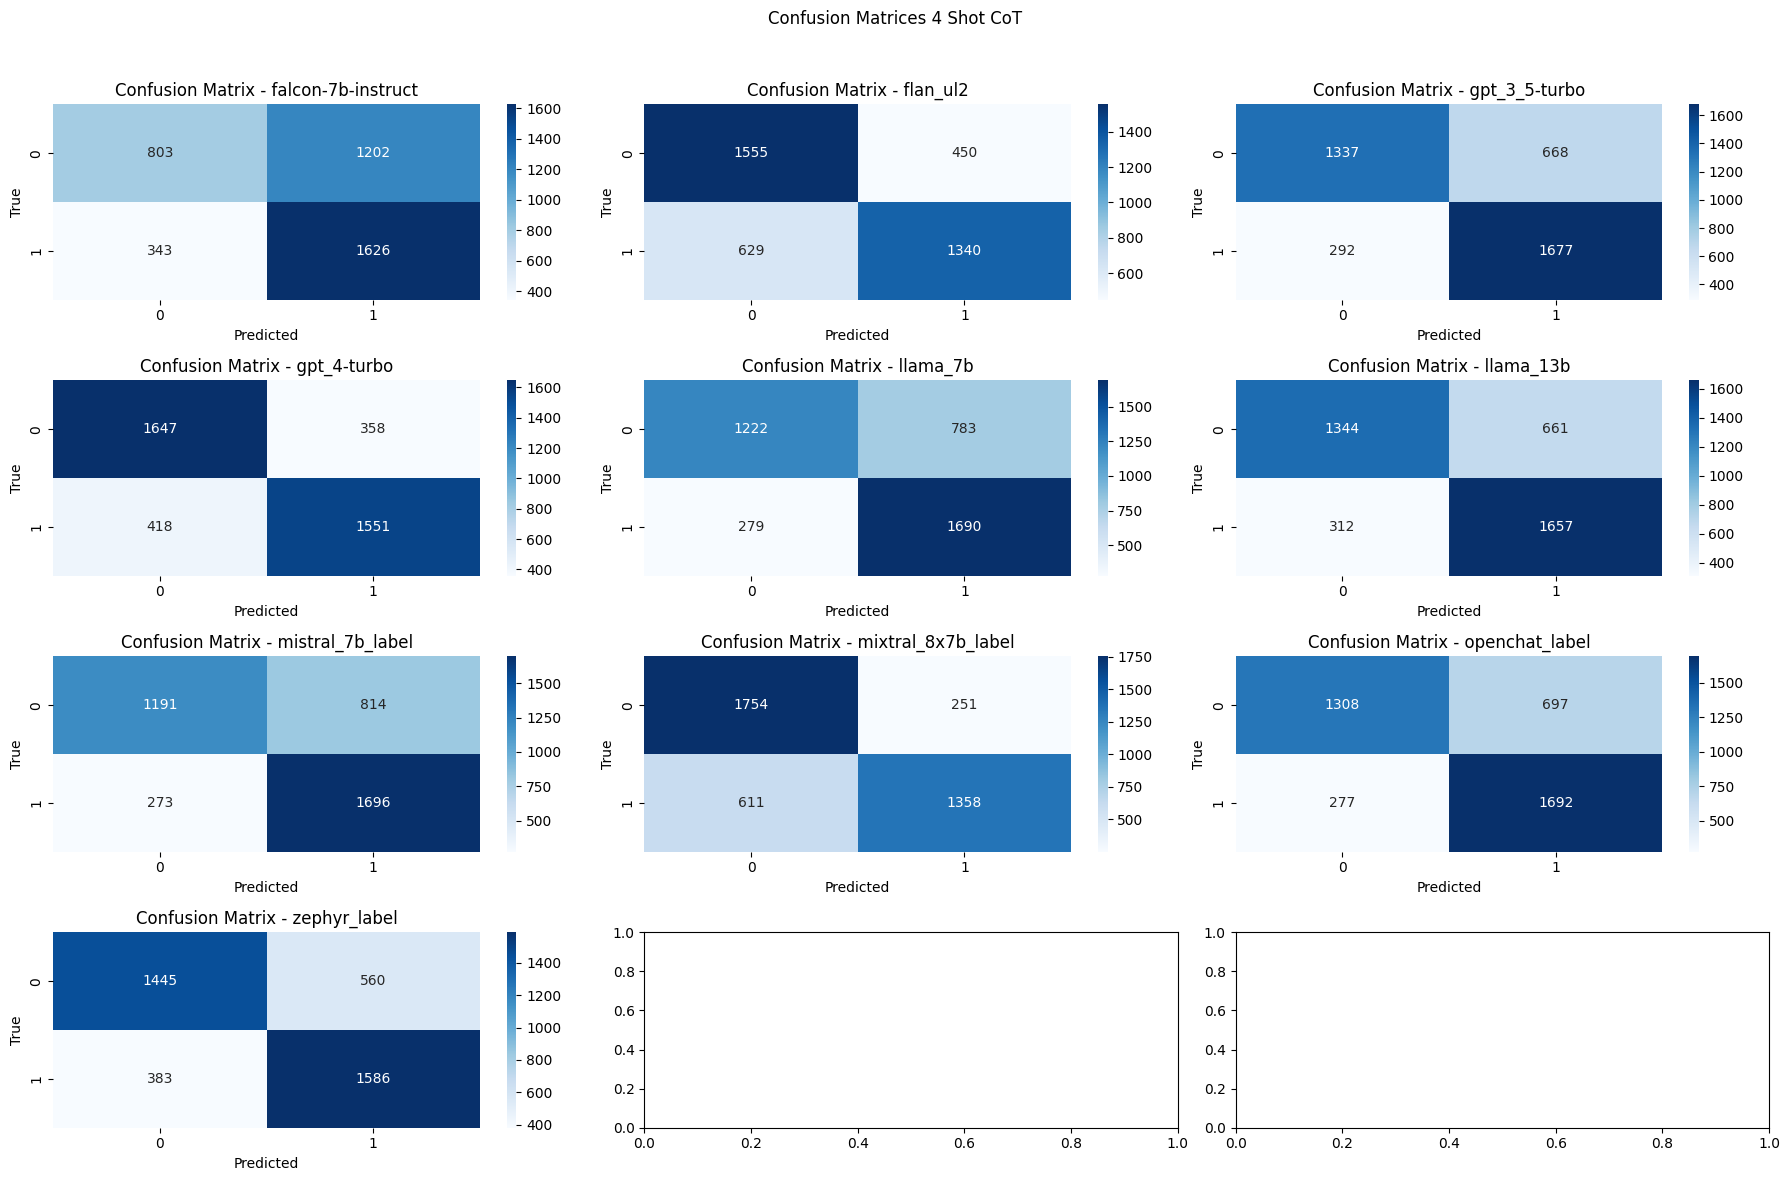

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


def plot_confusion_matrix(ax, df, true_labels_column, predicted_labels_column,
                          title=None
                          ):
    predicted_labels = df[f'{predicted_labels_column}'].astype(int)
    true_labels = df[f'{true_labels_column}'].astype(int)

    # Calculate confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)


    # Display confusion matrix heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=True,
                yticklabels=True, ax=ax)

    title = title if title else predicted_labels_column

    ax.set_title(f'Confusion Matrix - {title}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')


# Create subplots
fig, axes = plt.subplots(4, 3, figsize=(18, 12))
fig.suptitle('Confusion Matrices 4 Shot CoT')


#df_falcon_7b = pd.read_csv(f"./data/falcon-7b-instruct.csv")
#df_flan_ul2 = pd.read_csv(f"./data/flan-ul2.csv")
#df_openai_gpt_3_5_turbo = pd.read_csv('./data/gpt-3.5-turbo.csv')
#df_openai_gpt_4_turbo = pd.read_csv(f"./data/gpt-4-1106-preview.csv")
#df_Llama_2_7b = pd.read_csv(f"./data/Llama-2-7b-chat-hf.csv")
#df_Llama_2_13b = pd.read_csv(f"./data/Llama-2-13b-chat-hf.csv")
#df_mistral_7b = pd.read_csv(f"./data/Mistral-7B-Instruct-v0.1.csv")
#df_mixtral_8x7b = pd.read_csv(f"./data/Mixtral-8x7B-Instruct-v0.1.csv")
#df_openchat_3_5 = pd.read_csv(f"./data/openchat_3.5.csv")
#df_zephyr_7b_beta = pd.read_csv(f"./data/zephyr-7b-beta.csv")


# Plot each confusion matrix
plot_confusion_matrix(axes[0, 0], df_merge_all_runs, 'label', 'falcon_7b_label', 'falcon-7b-instruct')
plot_confusion_matrix(axes[0, 1], df_merge_all_runs, 'label', 'flan_ul2_label', 'flan_ul2')
plot_confusion_matrix(axes[0, 2], df_merge_all_runs, 'label', 'gpt_3_5_label', 'gpt_3_5-turbo')
plot_confusion_matrix(axes[1, 0], df_merge_all_runs, 'label', 'gpt_4_label', 'gpt_4-turbo')
plot_confusion_matrix(axes[1, 1], df_merge_all_runs, 'label', 'llama_7b_label', 'llama_7b')
plot_confusion_matrix(axes[1, 2], df_merge_all_runs, 'label', 'llama_13b_label', 'llama_13b')
plot_confusion_matrix(axes[2, 0], df_merge_all_runs, 'label', 'mistral_7b_label', 'mistral_7b_label')
plot_confusion_matrix(axes[2, 1], df_merge_all_runs, 'label', 'mixtral_8x7b_label', 'mixtral_8x7b_label')
plot_confusion_matrix(axes[2, 2], df_merge_all_runs, 'label', 'openchat_label', 'openchat_label')
plot_confusion_matrix(axes[3, 0], df_merge_all_runs, 'label', 'zephyr_label', 'zephyr_label')




plt.tight_layout(
    rect=[0, 0, 1, 0.96])  # Adjust layout to prevent title overlap
plt.show()

# Krippendorff Alpha in 4-shot CoT

In [53]:
from krippendorff import alpha
import numpy as np

runs = ['falcon_7b_label', 'flan_ul2_label',
       'gpt_3_5_label', 'gpt_4_label', 
       'llama_7b_label', 'llama_13b_label',
       'mistral_7b_label', 'mixtral_8x7b_label', 'openchat_label',
       'zephyr_label']


def compute_krippendorff_alpha(dataframe, columns, missing_data='?', verbose=False):
    """
    Compute Krippendorff's alpha for inter-rater reliability.

    Parameters:
    - dataframe: pd.DataFrame, the DataFrame containing the data.
    - columns: list, the list of column names to calculate alpha for.

    Returns:
    - alpha_value: float, Krippendorff's alpha value.
    """
    # Extract the relevant columns from the DataFrame
    data_subset = dataframe[columns]
    data_subset = data_subset.replace(missing_data, np.nan)

    # Ensure that the data is in a format suitable for krippendorff
    data_list = np.array([data_subset[col].tolist() for col in columns])

    if verbose:
        print(data_list.shape)

    # Calculate Krippendorff's alpha
    alpha_value = alpha(reliability_data=data_list)

    return alpha_value

In [54]:
alpha_value_with_errors = compute_krippendorff_alpha(df_merge_all_runs_with_errors, runs, verbose=True)
alpha_value_without_errors = compute_krippendorff_alpha(df_merge_all_runs, runs)

print(f"Krippendorff's Alpha (all runs with invalid data): {alpha_value_with_errors}")
print(f"Krippendorff's Alpha (all runs without invalid data): {alpha_value_without_errors}")

(10, 4021)
Krippendorff's Alpha (all runs with invalid data): 0.5377645055495124
Krippendorff's Alpha (all runs without invalid data): 0.5398538111611317


In [55]:
import itertools

def compute_krippendorff_alpha_for_k_runs(df, runs, k=None):
    # Initialize variables to store the best combination and alpha
    if k is None:
        k = len(runs)

    best_combination = None
    best_alpha = 0  # Assuming alpha ranges from 0 to 1

    # Iterate through all possible combinations
    for combination in itertools.combinations(runs, k):

        alpha_value = compute_krippendorff_alpha(df, list(combination))

        # Print alpha for the current combination
        print(f"Combination: {combination}, Alpha: {alpha_value}")

        # Update best combination and alpha if a higher alpha is found
        if alpha_value > best_alpha:
            best_alpha = alpha_value
            best_combination = combination

    # Print the best combination and alpha
    print(f"\nBest Combination: {best_combination}, Best Alpha: {best_alpha}")
    return best_alpha, best_combination

In [56]:
compute_krippendorff_alpha_for_k_runs(df_merge_all_runs_with_errors, runs, 2)

Combination: ('falcon_7b_label', 'flan_ul2_label'), Alpha: 0.17540181668938515
Combination: ('falcon_7b_label', 'gpt_3_5_label'), Alpha: 0.2371105605588315
Combination: ('falcon_7b_label', 'gpt_4_label'), Alpha: 0.19467506546492153
Combination: ('falcon_7b_label', 'llama_7b_label'), Alpha: 0.3231097391364288
Combination: ('falcon_7b_label', 'llama_13b_label'), Alpha: 0.27086059505295235
Combination: ('falcon_7b_label', 'mistral_7b_label'), Alpha: 0.32339874120696044
Combination: ('falcon_7b_label', 'mixtral_8x7b_label'), Alpha: 0.15549985348880146
Combination: ('falcon_7b_label', 'openchat_label'), Alpha: 0.3434175401314573
Combination: ('falcon_7b_label', 'zephyr_label'), Alpha: 0.323988744030943
Combination: ('flan_ul2_label', 'gpt_3_5_label'), Alpha: 0.49892953807528717
Combination: ('flan_ul2_label', 'gpt_4_label'), Alpha: 0.5538481708186064
Combination: ('flan_ul2_label', 'llama_7b_label'), Alpha: 0.44614023858652385
Combination: ('flan_ul2_label', 'llama_13b_label'), Alpha: 0.510

(0.753608415965835, ('gpt_4_label', 'mixtral_8x7b_label'))

In [57]:
compute_krippendorff_alpha_for_k_runs(df_merge_all_runs_with_errors, runs, 3)

Combination: ('falcon_7b_label', 'flan_ul2_label', 'gpt_3_5_label'), Alpha: 0.31438630966909575
Combination: ('falcon_7b_label', 'flan_ul2_label', 'gpt_4_label'), Alpha: 0.31787522524854483
Combination: ('falcon_7b_label', 'flan_ul2_label', 'llama_7b_label'), Alpha: 0.32401561070966656
Combination: ('falcon_7b_label', 'flan_ul2_label', 'llama_13b_label'), Alpha: 0.3294645683465628
Combination: ('falcon_7b_label', 'flan_ul2_label', 'mistral_7b_label'), Alpha: 0.3168454549299268
Combination: ('falcon_7b_label', 'flan_ul2_label', 'mixtral_8x7b_label'), Alpha: 0.3126444665738335
Combination: ('falcon_7b_label', 'flan_ul2_label', 'openchat_label'), Alpha: 0.34404630905270417
Combination: ('falcon_7b_label', 'flan_ul2_label', 'zephyr_label'), Alpha: 0.35142708580458293
Combination: ('falcon_7b_label', 'gpt_3_5_label', 'gpt_4_label'), Alpha: 0.3798968957781734
Combination: ('falcon_7b_label', 'gpt_3_5_label', 'llama_7b_label'), Alpha: 0.39650327447561484
Combination: ('falcon_7b_label', 'gpt_

(0.686709095619648, ('llama_13b_label', 'openchat_label', 'zephyr_label'))

In [58]:
df_merge_all_runs.shape

(3974, 18)

In [59]:
df_merge_all_runs.query("gpt_4_label != mixtral_8x7b_label").shape

(484, 18)